# Changepoint detection and deviation detection
Notebook containing experimental evaluation of deviation detection methods.

In [1]:
import numpy as np
import os, sys
import math
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
%matplotlib inline 
#from my_functions import *
from modules.preprocessing import *
from modules.statistics import *
from modules.io import *
from modules.learning import *
from scipy import stats
from ast import literal_eval

#from modules.experiments import *
import matplotlib.dates as mdates


## Read data
Read input time series. Manual washing dates are given as input. 

In [2]:
file_arrays = "/data/data2/inaccess/extracted_data/arrays.csv"
file_arrays_day = "/data/data2/inaccess/extracted_data/arrays_per_day.csv"
file_weather = "/data/data2/inaccess/extracted_data/weather.csv"
file_expected = "/data/data2/inaccess/extracted_data/expected_power.csv"

no_arrays = 14
dates_wash_start = pd.to_datetime(pd.Series(['2021-04-15 00:00:00', '2020-10-22 00:00:00', '2020-06-01 00:00:00', '2019-07-25 00:00:00', '2019-05-22 00:00:00', '2018-09-02 00:00:00', '2018-05-31 00:00:00', '2017-05-12 00:00:00', '2016-10-17 00:00:00', '2016-07-30 00:00:00', '2016-06-25 00:00:00', '2015-06-25 00:00:00', '2015-08-03 00:00:00', '2014-08-06 00:00:00', '2014-06-02 00:00:00']))
dates_wash_stop = pd.to_datetime(pd.Series(['2021-04-19 00:00:00', '2020-10-26 00:00:00', '2020-06-05 00:00:00', '2019-07-29 00:00:00', '2019-05-26 00:00:00', '2018-09-06 00:00:00', '2018-06-04 00:00:00', '2017-05-16 00:00:00', '2016-10-21 00:00:00', '2016-08-03 00:00:00', '2016-06-29 00:00:00', '2015-06-29 00:00:00', '2015-08-07 00:00:00', '2014-08-10 00:00:00', '2014-06-06 00:00:00']))

scaler = MinMaxScaler()
df_weather = pd.read_csv(file_weather).set_index('measurement_time')
df_weather = df_weather.rename_axis('timestamp')
df_weather.index = pd.to_datetime(df_weather.index)
df_weather = df_weather.iloc[: , :-1]
print(df_weather.columns)
df_weather.columns = [ 'mean_irradiance','air_temp', 'mean_mod_temp', 'precipitation', 'humidity', 'wind_dir', 'wind_speed']
df_weather_clean = df_weather.dropna(subset=['precipitation']).copy().sort_index()
#df_weather_clean.head()
df_weather_scaled = pd.DataFrame(scaler.fit_transform(df_weather_clean), columns=df_weather_clean.columns, index=df_weather_clean.index)
df_weather_scaled.head()

Index(['Average Irradiance', 'Average ambient air temperature',
       'Average module temperature', 'Average precipitation',
       'Average relative humidity', 'Average wind direction',
       'Average wind speed'],
      dtype='object')


,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed
timestamp,,,,,,,
2014-01-01 00:00:00,0.005383,0.515894,0.240814,9.275331e-10,0.854536,0.279050,2.613575e-07
2014-01-01 00:15:00,0.006296,0.518888,0.238498,2.318799e-09,0.874373,0.270916,2.749406e-07
2014-01-01 00:30:00,0.012483,0.516374,0.237450,3.478352e-09,0.885812,0.258940,3.040241e-07
2014-01-01 00:45:00,0.017354,0.514967,0.236895,4.405853e-09,0.885461,0.261322,3.053200e-07
2014-01-01 01:00:00,0.022735,0.515866,0.235946,6.029187e-09,0.894617,0.242502,3.601820e-07


In [3]:
df_arrays = pd.read_csv(file_arrays).set_index('measurement_time')
df_arrays = df_arrays.rename_axis('timestamp')
print(df_arrays.columns)
df_arrays.columns = [ 'array_name', 'mod_temp', 'power', 'irradiance']
df_arrays.index = pd.to_datetime(df_arrays.index)
#df_arrays = df_arrays.between_time(start, end)#.dropna()
df_grouped_arrays = [x for _, x in df_arrays.groupby(['array_name'],sort=True)]
dict_arrays = {}
dict_scaled_arrays = {}
scaler = MinMaxScaler()
for df_one_array in df_grouped_arrays:
    key = df_one_array.array_name[0]
    df_new_array = df_one_array[['mod_temp', 'power', 'irradiance']]#.join(df_weather_clean)
    #print(f'Irradiance: mean: {np.mean(df_new_array.irradiance)}, variance: {np.var(df_new_array.irradiance)}, standard deviation: {np.sqrt(np.var(df_new_array.irradiance))}')
    #filter irradiance:
    #df_new_array = df_new_array[df_new_array.irradiance>500]
    df_new_array = df_new_array.rolling('2s').mean().dropna()
    #df_new_array = pd.DataFrame(scaler.fit_transform(df_new_array), columns=df_new_array.columns, index=df_new_array.index)
    #df_new_array = df_new_array.join(df_weather_scaled)
    df_new_array.index = df_new_array.index.round(freq = '15T')
    dict_arrays[key] = df_new_array.interpolate() #dict_arrays[key]



Index(['segment_name', 'Module Temperature', 'Panel group output power',
       'Total Irradiance'],
      dtype='object')


In [4]:
#df = dict_scaled_arrays['Array 4'].join(df_weather_clean)   
df_scaled = dict_arrays['Array 4']
df = df_scaled[['mod_temp', 'power', 'irradiance']].join(df_weather_clean)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

Aging effect

In [5]:
df_normal = dict_arrays['Array 4']
# for Inaccess data:
aging_by_year = np.array([2.5, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]) / 100
op_years = [('2014-01-01 00:00:00', '2015-01-01 00:00:00'),('2015-01-01 00:00:00', '2016-01-01 00:00:00'),('2016-01-01 00:00:00', '2017-01-01 00:00:00'),('2017-01-01 00:00:00', '2018-01-01 00:00:00'),('2018-01-01 00:00:00', '2019-01-01 00:00:00'),
('2019-01-01 00:00:00', '2020-01-01 00:00:00'),
('2020-01-01 00:00:00', '2021-01-01 00:00:00'),
('2021-01-01 00:00:00', '2022-01-01 00:00:00')]

#for j in range(no_arrays):
df_coefs = pd.DataFrame(columns=['coef'], index=df_scaled.index)
prev_factor = 1
for i, (start, end) in enumerate(op_years):
    factor = aging_by_year[i]
    c = np.linspace(prev_factor, prev_factor + factor, df_coefs[start:end].values.shape[0])
    df_coefs['coef'][start:end] = c
    prev_factor = prev_factor + factor
#dict_scaled_arrays['Array '+str(j+1)]['normalized_power'] = dict_scaled_arrays['Array '+str(j+1)].normalized_power * df_coefs.coef
df_scaled['normalized_power'] = df_scaled.power * df_coefs.coef
df_normal['normalized_power'] = df.power * df_coefs.coef

#df_coefs.plot()

In [6]:
df_scaled = df_scaled['2015':'2020']
#df = df['2015':'2020'] 

In [7]:
df_scaled.head()

,mod_temp,power,irradiance,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed,normalized_power
timestamp,,,,,,,,,,,
2015-01-01 00:00:00,0.187458,0.0,0.0,0.0,0.171675,0.187458,0.0,0.487629,0.263670,7.093931e-07,0.0
2015-01-01 00:15:00,0.187473,0.0,0.0,0.0,0.173191,0.187473,0.0,0.481282,0.255973,6.687820e-07,0.0
2015-01-01 00:30:00,0.188379,0.0,0.0,0.0,0.174540,0.188379,0.0,0.476458,0.276733,6.643006e-07,0.0
2015-01-01 00:45:00,0.187969,0.0,0.0,0.0,0.176390,0.187969,0.0,0.469628,0.245252,6.483727e-07,0.0
2015-01-01 01:00:00,0.188010,0.0,0.0,0.0,0.178239,0.188010,0.0,0.463259,0.238244,6.305383e-07,0.0


In [8]:
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns, index=df_scaled.index)
start = '11:00'
end = '16:00'

In [9]:
# #df_scaled.info()
# df.head()

In [10]:
df_scaled.describe()

,mod_temp,power,irradiance,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed
count,205685.000000,205685.000000,205685.000000,205679.000000,205676.000000,205679.000000,2.056800e+05,205652.000000,205650.000000,2.056510e+05
mean,0.406002,0.188896,0.179670,0.179668,0.436530,0.406002,1.267088e-09,0.742085,0.586942,2.490147e-07
std,0.165392,0.270136,0.256920,0.256922,0.146541,0.165393,6.336701e-09,0.193396,0.209565,1.970249e-07
min,0.006058,0.000000,0.000000,0.000000,0.000000,0.006058,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,0.280752,0.000000,0.000000,0.000000,0.324712,0.280751,0.000000e+00,0.616352,0.391952,8.528017e-08
50%,0.385164,0.000000,0.001210,0.001208,0.421475,0.385159,0.000000e+00,0.768497,0.663790,2.095243e-07
75%,0.502462,0.359633,0.330452,0.330447,0.548974,0.502465,0.000000e+00,0.906210,0.760516,3.801455e-07
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.266499e-06,1.000000,1.000000,1.065085e-05


## Extract rains
Use precipitation values to extract rains. Each rain corresponds to a maximal period of positive precipitation.

In [11]:
if df.precipitation.iloc[0]>0:
    precipitation = pd.concat([pd.Series({min(df.index)-pd.Timedelta('1s'): 0}),df.precipitation])
else:
    precipitation = df.precipitation

precipitation.index = pd.to_datetime(precipitation.index)
df_dates = pd.DataFrame(index = precipitation.index)
df_dates["rain_start"] = precipitation[(precipitation.shift(-1) > 0) & (precipitation == 0)] # compare current to next
df_dates["rain_stop"] = precipitation[(precipitation.shift(1) > 0) & (precipitation == 0)] # compare current to prev
dates_rain_start = pd.Series(df_dates.rain_start.index[df_dates.rain_start.notna()])
dates_rain_stop = pd.Series(df_dates.rain_stop.index[df_dates.rain_stop.notna()])

Number of rains:

In [12]:
dates_rain_stop.shape[0]

800

### Filter out light rains
Any rain with maximum precipitation less than x is considered light.

In [13]:
x = 0.1
ids = []
for idx in range(dates_rain_start.size):
    d1 = dates_rain_start[idx]
    d2 = dates_rain_stop[idx]
    if np.max(precipitation.loc[d1:d2]) >= x:
        ids.append(idx)
dates_rain_start_filtered = dates_rain_start[ids]
dates_rain_stop_filtered = dates_rain_stop[ids]

Number of remaining rains:

In [14]:
dates_rain_stop_filtered.shape[0]


457

In [15]:
df_scaled = df_scaled.between_time(start, end)


In [16]:
df_scaled

,mod_temp,power,irradiance,mean_irradiance,air_temp,mean_mod_temp,precipitation,humidity,wind_dir,wind_speed,normalized_power
timestamp,,,,,,,,,,,
2015-01-01 11:00:00,0.262201,0.217119,0.195806,0.195806,0.194299,0.262201,9.286120e-10,0.574412,0.220897,2.527626e-07,0.222549
2015-01-01 11:15:00,0.261108,0.210110,0.171176,0.171176,0.200366,0.261108,9.286197e-10,0.585990,0.263717,2.195807e-07,0.215364
2015-01-01 11:30:00,0.242949,0.169904,0.141649,0.141649,0.197482,0.242949,9.286237e-10,0.583670,0.205019,3.416267e-07,0.174153
2015-01-01 11:45:00,0.259377,0.239102,0.201156,0.201156,0.201561,0.259377,9.286254e-10,0.567073,0.200167,3.328823e-07,0.245082
2015-01-01 12:00:00,0.284223,0.273906,0.222314,0.222314,0.208630,0.284223,9.286214e-10,0.554002,0.173037,3.456093e-07,0.280756
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 15:00:00,0.314570,0.047429,0.057017,0.057017,0.363850,0.314570,0.000000e+00,0.808115,0.602925,2.666693e-07,0.050606
2020-12-31 15:15:00,0.288592,0.016515,0.014290,0.014290,0.352909,0.288592,0.000000e+00,0.672706,0.598689,2.524120e-07,0.017621
2020-12-31 15:30:00,0.273836,0.000000,0.000138,0.000138,0.348467,0.273836,1.472653e-08,0.674181,0.608833,2.242566e-07,0.0


### Regression model trained after manual cleanings 
Train a regression model on periods of w_train days after the manual washings of the panels.

In [17]:
w_train = 30
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
ref_points2 = pd.Index(dates_wash_stop)
model2, training_error2, validation_error2 = train_on_reference_points(df_scaled, w_train, ref_points2, feats, target)
validation_error2

Training Metrics:
MAE:0.017 
ME(true-pred):0.000 
MAPE:0.035 
R2: 0.985

Validation Metrics:
MAE:0.018 
ME(true-pred):-0.001 
MAPE:0.037 
MPE:-0.002 
R2: 0.982



array([ 9.81893447e-01,  1.84855641e-02, -8.97130643e-04,  3.74524628e-02,
       -1.81762114e-03,  9.90018150e-01])

In [18]:
df_scaled[target].head()



timestamp
2015-01-01 11:00:00    0.222549
2015-01-01 11:15:00    0.215364
2015-01-01 11:30:00    0.174153
2015-01-01 11:45:00    0.245082
2015-01-01 12:00:00    0.280756
Name: normalized_power, dtype: object

## Detect changepoints

Two methods for detecting changepoints. 
Method 1. For each rain (or manual cleaning), we train and validate a regression model in the time period right before it, and we test it in the time period right after it. We then employ a score function which ranks preferably those rains with a small error before them and a large error after them. 
Method 2. We use the model trained on periods succeeding manual cleanings. For each rain (or manual cleaning), we measure the prediction error in the time period right before it, and the prediction error in the time period right after it. We then employ a score function which ranks preferably those rains with a large error before them and a small error after them.

### Initialize parameters

In [19]:
w1 = 10  # window of days to train (before the rain)
w2 = 5 # window of days to validate (before the rain)
w3 = 10 # window of days to test (after the rain)

error_br_column = 5 #0=r_squared, 1=mae, 2=me, 3=mape, 4=mpe, 5=median error
error_ar_column = 5
thrsh = 1

In [20]:
errors_br1 = np.empty((dates_rain_start_filtered.size, 6))
errors_ar1 = np.empty((dates_rain_start_filtered.size, 6))
scores = np.empty((dates_rain_start_filtered.size))
indices = np.empty(len(scores), dtype=int)
error_names = {0: "r_squared", 1: "MAE", 2: "ME (true-pred)", 3: "MAPE", 4: "MPE (true-pred)", 5: "Median error"}

### Detect changepoints

In [21]:
p_changepoints_start = (pd.Series(dates_rain_start_filtered.tolist() + dates_wash_start.tolist()).sort_values())
p_changepoints_stop = (pd.Series(dates_rain_stop_filtered.tolist() + dates_wash_stop.tolist()).sort_values())
target = 'normalized_power'
feats = ['irradiance', 'mod_temp']
error_name_br = error_names[error_br_column] 
error_name_ar = error_names[error_ar_column]

#compute errors using one model per rain
errors_br1, errors_ar1, errors_all1 = calc_changepoints_many_models(df_scaled, p_changepoints_start, p_changepoints_stop, target, feats, w1, w2, w3 )
errors_br2, errors_ar2, errors_all2 = calc_changepoints_one_model(df_scaled, p_changepoints_start, p_changepoints_stop, model2, target, feats, 5, 10)

#set threshold on MAPE error before rain
mask1 = (errors_br1[:,3]<= 0.05)
mask2 = (errors_ar2[:,3]<= 0.05)

#compute scores for the remaining
#scores1 = -(errors_br1[:, error_br_column]-errors_ar1[:, error_ar_column])/np.abs(errors_br1[:, error_ar_column])

#scores for ratios:
#scores1 = errors_ar1[:, error_ar_column]/np.abs(errors_br1[:, error_ar_column])
scores1 = errors_all1

scores1[(~mask1)] = np.finfo('d').min



#scores2 = -(errors_br2[:, error_br_column]-errors_ar2[:, error_ar_column])/np.abs(errors_ar2[:, error_ar_column])
#scores for ratios:
#scores2 = errors_br2[:, error_br_column]/np.abs(errors_ar2[:, error_ar_column])
scores2 = errors_all2
scores2[(~mask2)] = np.finfo('d').min

#sort
indices1 = np.argsort(-scores1)
indices2 = np.argsort(-scores2)

#compute final output
precip = df.precipitation
df_events_output1=pd.DataFrame(output_changepoints(scores1, indices1, p_changepoints_start, p_changepoints_stop, errors_br1[:, error_br_column], errors_ar1[:, error_ar_column], error_name_br, error_name_ar, precip))
df_events_output2=pd.DataFrame(output_changepoints(scores2, indices2, p_changepoints_start, p_changepoints_stop, errors_br2[:, error_br_column], errors_ar2[:, error_ar_column], error_name_br, error_name_ar, precip))

# effective changepoints = the ones with score at least thrsh  
thrsh = np.quantile(df_events_output1['Score'].values, 0.9)
mask1 = (df_events_output1['Score']>thrsh)

thrsh = np.quantile(df_events_output2['Score'].values, 0.9)
mask2 = (df_events_output2['Score']>thrsh)

effective_cp1 = df_events_output1[mask1]["id"].values 
effective_cp2 = df_events_output2[mask2]["id"].values 

print(f'Number of "effective" changepoints using Method 1: {len(set(effective_cp1))}') 
print(f'Number of "effective" changepoints using Method 2: {len(set(effective_cp2))}') 



Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the training set is empty or the test set is empty
Either the tra

/home/ipsarros/more_venv2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float divis

/home/ipsarros/more_venv2/lib/python3.8/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Train model after changepoints computed by Method 1

In [22]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)]))
model1, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.025 
ME(true-pred):0.000 
MAPE:0.050 
R2: 0.975

Validation Metrics:
MAE:0.024 
ME(true-pred):-0.000 
MAPE:0.049 
MPE:-0.000 
R2: 0.976



array([ 9.75592343e-01,  2.40785565e-02, -2.26864563e-05,  4.91791602e-02,
       -4.63358702e-05,  9.87722930e-01])

### Train model after changepoints computed by Method 2

In [23]:
ref_points = pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)]))
model3, training_error, validation_error = train_on_reference_points(df_scaled, w_train, ref_points, feats, target)
validation_error

Training Metrics:
MAE:0.013 
ME(true-pred):-0.000 
MAPE:0.026 
R2: 0.990

Validation Metrics:
MAE:0.013 
ME(true-pred):-0.000 
MAPE:0.025 
MPE:-0.000 
R2: 0.989



array([ 9.88937643e-01,  1.25900264e-02, -9.60634460e-05,  2.46852066e-02,
       -1.88351155e-04,  1.00160333e+00])

### Compare three regression models

<class 'pandas.core.series.Series'>


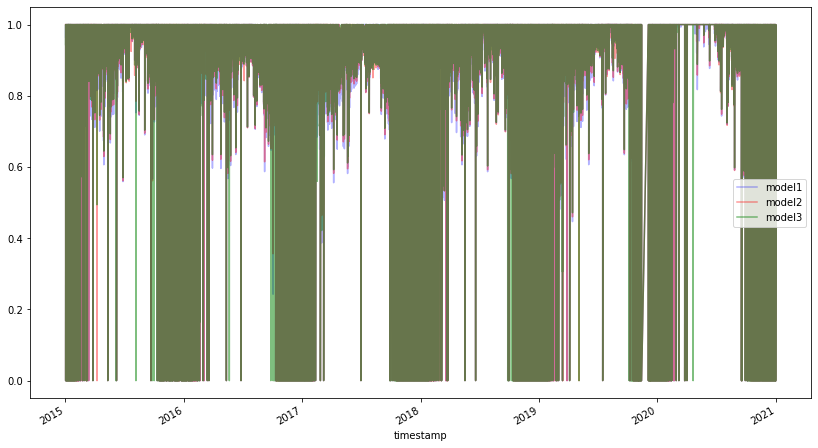

In [24]:
y_pred1 = predict(df_scaled, model1, feats, target)
y_pred2 = predict(df_scaled, model2, feats, target)
y_pred3 = predict(df_scaled, model3, feats, target)
derate1 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred1,1),0.0)
print(type(derate1))
plt.figure(figsize = (14,8))
derate1_smooth = derate1.rolling('1D', min_periods=1,center = True).median()
derate2 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred2,1),0.0)
derate2_smooth = derate2.rolling('1D', min_periods=1, center = True).median()
derate3 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred3,1),0.0)
derate3_smooth = derate3.rolling('1D', min_periods=1, center = True).median()
#ax1 = df['soiling_derate'].plot(figsize=(12,8), color = 'goldenrod',label = 'soiling ratio')
ax1 = derate1.plot(color = 'blue', alpha = 0.3, label = 'model1')
ax1.plot(derate2, color = 'red', alpha = 0.4, label = 'model2')
ax1.plot(derate3, color = 'green', alpha = 0.5, label = 'model3')
plt.legend()

## Segmentation using changepoints obtained by Method 1

In [25]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp1)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 1. 

In [26]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes = []
mpe_scores = []
sign_slopes = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes.append(-slope)
        sign_slopes.append(np.sign(-slope))
    except:
        sign_slopes.append(np.finfo('d').min)
        slopes.append(np.finfo('d').min)
        mpe_scores.append(1)

### Compute output

In [27]:
indices = np.argsort(np.array(mpe_scores)*(np.array(sign_slopes)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes[j] > 0 and mpe_scores[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model1, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes[j]*mpe_scores[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [28]:
df_segments_output

,Score,Starting date,Ending date
0,0.041632,2018-02-26 09:30:00,2018-05-06 19:15:00
1,0.038724,2019-03-13 04:30:00,2019-03-27 19:15:00
2,0.034914,2020-08-05 05:00:00,2021-10-04 23:45:00
3,0.033871,2018-09-26 13:15:00,2019-03-12 07:00:00
4,0.032673,2016-03-13 23:45:00,2016-03-23 19:30:00
5,0.032323,2019-04-06 18:45:00,2019-05-16 22:00:00
6,0.031647,2016-03-27 08:45:00,2016-06-25 12:30:00
7,0.029188,2016-03-25 17:45:00,2016-03-26 23:15:00
8,0.026917,2018-05-27 22:15:00,2018-05-31 00:00:00
9,0.026441,2016-06-29 00:00:00,2016-09-25 22:00:00


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings. 

In [29]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes3 = []
mpe_scores3 = []
sign_slopes3 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores3.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes3.append(-slope)
        sign_slopes3.append(np.sign(-slope))
    except:
        sign_slopes3.append(np.finfo('d').min)
        slopes3.append(np.finfo('d').min)
        mpe_scores3.append(1)

### Compute output

In [30]:
indices = np.argsort(np.array(mpe_scores3)*(np.array(sign_slopes3)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes3[j] > 0 and mpe_scores3[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes3[j]*mpe_scores3[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
        line , slope, _ = get_ts_line_and_slope(diff.values)
                        
df_segments_output3 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [31]:
df_segments_output3

,Score,Starting date,Ending date
0,0.028386,2017-02-21 16:45:00,2017-06-07 20:30:00
1,0.021365,2016-06-29 00:00:00,2016-09-25 22:00:00
2,0.021295,2018-06-27 19:00:00,2018-09-02 00:00:00
3,0.018085,2018-06-16 14:30:00,2018-06-25 06:30:00
4,0.016968,2018-05-27 22:15:00,2018-05-31 00:00:00
5,0.015986,2020-08-05 05:00:00,2021-10-04 23:45:00
6,0.015974,2018-05-07 11:45:00,2018-05-27 12:30:00
7,0.014974,2018-06-04 00:00:00,2018-06-15 13:00:00
8,0.014797,2016-03-27 08:45:00,2016-06-25 12:30:00
9,0.014641,2018-02-26 09:30:00,2018-05-06 19:15:00


## Segmentation using changepoints obtained by Method 2

In [32]:
dates_changepoints = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])
# these dates are used by the deviation detection tool
dates_start = (pd.Index(pd.Series(p_changepoints_start.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_stop = (pd.Index(pd.Series(p_changepoints_stop.iloc[list(effective_cp2)].tolist()).sort_values()))
dates_start = dates_start.union([max(df.index)])
dates_stop = dates_stop.union([min(df.index)])

### Assign scores to segments using model trained after changepoints
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after changepoints obtained by Method 2. 

In [33]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes4 = []
mpe_scores4 = []
sign_slopes4 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores4.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes4.append(-slope)
        sign_slopes4.append(np.sign(-slope))
    except:
        sign_slopes4.append(np.finfo('d').min)
        slopes4.append(np.finfo('d').min)
        mpe_scores4.append(1)



### Compute output

In [34]:
indices = np.argsort(np.array(mpe_scores4)*(np.array(sign_slopes4)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) 
    except:
        d3 = d2
        d4 = d2
    if slopes4[j] > 0 and mpe_scores4[j]<0 and len(df_scaled.loc[d1:d2])>0: 
        y_pred = predict(df_scaled.loc[d1:d2], model3, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes4[j]*mpe_scores4[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
       
        line , slope, _ = get_ts_line_and_slope(diff.values)
        
                
df_segments_output4 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [35]:
df_segments_output4

,Score,Starting date,Ending date
0,0.084884,2016-04-10 11:45:00,2016-04-10 12:45:00
1,0.016588,2016-09-26 10:00:00,2017-05-25 22:45:00
2,0.014788,2016-08-03 00:00:00,2016-09-25 22:00:00
3,0.014590,2017-05-29 00:00:00,2017-06-07 20:30:00
4,0.011231,2017-07-17 05:15:00,2017-08-30 07:15:00
5,0.011157,2018-06-28 19:00:00,2018-09-02 00:00:00
6,0.010272,2018-03-24 16:15:00,2018-05-27 12:30:00
7,0.004765,2016-05-05 11:45:00,2016-05-21 19:00:00
8,0.003860,2018-06-20 01:30:00,2018-06-25 06:30:00
9,0.003081,2016-05-22 06:15:00,2016-06-25 00:00:00


### Assign scores to segments using model trained after manual cleanings
Compute slopes and mpe errors. Expected power output is modelled using the regression model trained after manual cleanings.

In [36]:
feats = ['irradiance', 'mod_temp']
target = 'normalized_power'
slopes2 = []
mpe_scores2 = []
sign_slopes2 = []
for j, d2 in enumerate(dates_start):
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    try:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        diff = (df_scaled.loc[d1:d2].normalized_power - y_pred).values
        line , slope, _ = get_ts_line_and_slope(diff)
        mpe_scores2.append(st.score_segment(df_scaled.loc[d1:d2].normalized_power, y_pred)[0])
        slopes2.append(-slope)
        sign_slopes2.append(np.sign(-slope))
    except:
        sign_slopes2.append(np.finfo('d').min)
        slopes2.append(np.finfo('d').min)
        mpe_scores2.append(1)



### Compute output

In [37]:
indices = np.argsort(np.array(mpe_scores2)*(np.array(sign_slopes2)))
all_scores = [] 
all_dates_start = []
all_dates_end = []
for j in indices:
    d2 = dates_start[j]
    d1 = dates_stop[dates_stop.get_loc(d2, method='pad')]
    #print(f"{d1} - {d2}")
    try: 
        d3 = dates_stop[dates_stop.get_loc(d2, method='bfill')]
        d4 = d3 + pd.to_timedelta(d2-d1) ####################
    except:
        d3 = d2
        d4 = d2
    if slopes2[j] > 0 and mpe_scores2[j]<0 and len(df_scaled.loc[d1:d2])>0: #and len(df_scaled.loc[d3:d4])>0:
        y_pred = predict(df_scaled.loc[d1:d2], model2, feats, target)
        all_dates_start.append(d1)
        all_dates_end.append(d2)
        all_scores.append(-sign_slopes2[j]*mpe_scores2[j])
        diff = ((df_scaled.loc[d1:d2].normalized_power - y_pred))
        
                
df_segments_output2 = (pd.DataFrame.from_dict({"Score": all_scores, "Starting date": all_dates_start, "Ending date": all_dates_end}))    


### Print output

In [38]:
df_segments_output2

,Score,Starting date,Ending date
0,0.064600,2016-04-10 11:45:00,2016-04-10 12:45:00
1,0.032883,2017-05-29 00:00:00,2017-06-07 20:30:00
2,0.029011,2016-08-03 00:00:00,2016-09-25 22:00:00
3,0.021835,2018-03-24 16:15:00,2018-05-27 12:30:00
4,0.021338,2016-09-26 10:00:00,2017-05-25 22:45:00
5,0.021283,2016-05-05 11:45:00,2016-05-21 19:00:00
6,0.021267,2018-06-28 19:00:00,2018-09-02 00:00:00
7,0.019208,2016-05-22 06:15:00,2016-06-25 00:00:00
8,0.019197,2016-05-22 06:15:00,2016-06-25 12:30:00
9,0.018085,2018-06-20 01:30:00,2018-06-25 06:30:00


## Plots

### Changepoints

In [39]:
dates_changepoints1 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp1)])
dates_changepoints2 = pd.DatetimeIndex(p_changepoints_stop.iloc[list(effective_cp2)])


In [40]:
def plotlines(df, timestamps):
    t1 = min(df.index)
    t2 = max(df.index)
    newtimestamps = timestamps.sort_values()
    newtimestamps = newtimestamps.insert(0,t1)
    newtimestamps = newtimestamps.insert(len(newtimestamps),t2)
    lines = []
    s = 0
    for t1, t2 in zip(newtimestamps[:-1], newtimestamps[1:]):
        if (len(df[t1:t2])>0):
            line , slope, _ = get_ts_line_and_slope(df[t1:t2].values)
            s = s+len(df[t1:t2].index)
            if slope < 0 :
                lines = lines + [pd.Series(line, index = df[t1:t2].index)]
            else:
                lines = lines + [pd.Series([np.nan]*len(df[t1:t2].index), index = df[t1:t2].index)]

        #else:
        #    lines = lines + [df[t1]]
    plt.plot(pd.concat(lines), color = 'red', ls = '--')

In [41]:
start = pd.Timestamp('2016-01-01')
end = pd.Timestamp('2020-12-31')

#### Method 1

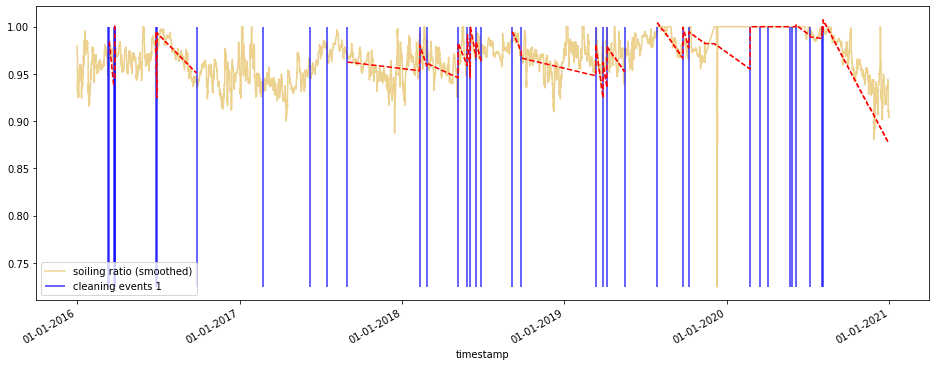

In [42]:
#ymin = min(df['soiling_derate'].values)

#ax1 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate',figsize=(12,8))
derate1 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred1,1),0.0)

#derate1 = df_scaled.normalized_power - y_pred1 
derate1_smooth = derate1.rolling('4D', min_periods=1,center = True).median()
#derate1_smooth = derate1
ymin = min(derate1_smooth)
ymax = max(derate1_smooth)
ax1 = derate1_smooth[start:end].plot( color = 'goldenrod', label='soiling ratio (smoothed)',figsize=(16,6), alpha = 0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.vlines(x=dates_changepoints1.intersection(pd.date_range(start = start, end = end, freq = '15T')), ymin=ymin, ymax=ymax, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')
ax1.xaxis.set_major_locator(mdates.YearLocator())


plotlines(derate1[start:end], dates_changepoints1.intersection(pd.date_range(start = start, end = end, freq = '15T')))
#ax1.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
#ax1.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
#b=0.92
#ax1.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax1.legend()
plt.show()

#### Method 2

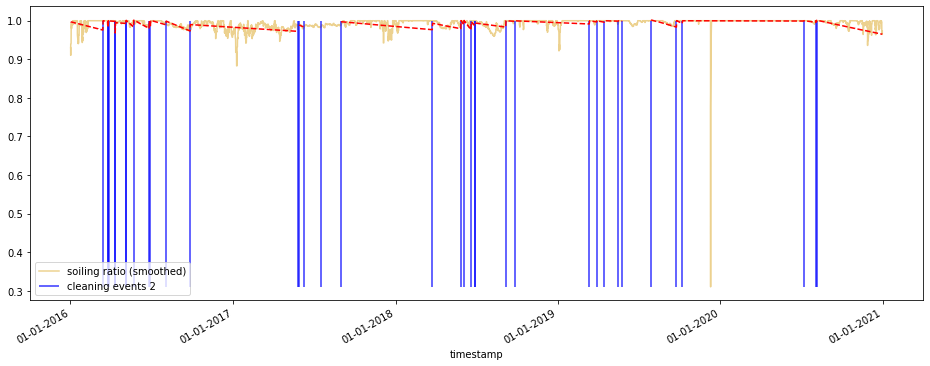

In [43]:
#ymin = min(df['soiling_derate'].values)
#ax2 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate', figsize=(12,8))

derate3 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred3,1),0.0)
#derate3 = df_scaled.normalized_power - y_pred3

derate3_smooth = derate3.rolling('4D', min_periods=1,center = True).median()
#derate3_smooth = derate3
ymin = min(derate3_smooth)
ymax = max(derate3_smooth)

ax2 = derate3_smooth[start:end].plot( color = 'goldenrod', label='soiling ratio (smoothed)', figsize=(16,6), alpha = 0.5) 
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.vlines(x=dates_changepoints2.intersection(pd.date_range(start = start, end = end, freq = '15T')), ymin=ymin, ymax=ymax, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')
ax2.xaxis.set_major_locator(mdates.YearLocator())

#ax2.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
#ax2.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
#b=0.92
#ax2.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
plotlines(derate3[start:end], dates_changepoints2.intersection(pd.date_range(start = start, end = end, freq = '15T')))

ax2.legend()
plt.show()

#### Method 1- Derate 2 (manual cleanings)

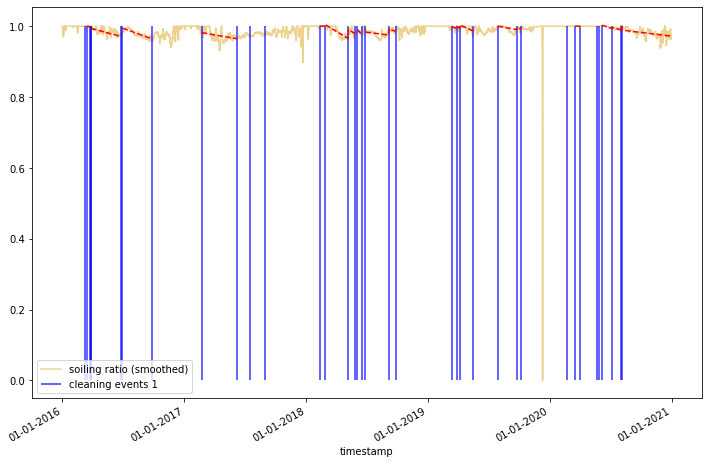

In [44]:
#ymin = min(df['soiling_derate'].values)
#ax1 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate',figsize=(12,8))
derate2 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred2,1),0.0)

derate2_smooth = derate2.rolling('4D', min_periods=1,center = True).median()

ymin = min(derate2_smooth)
ymax = max(derate2_smooth)

ax1 = derate2_smooth[start:end].plot( color = 'goldenrod', label='soiling ratio (smoothed)',figsize=(12,8), alpha = 0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.vlines(x=dates_changepoints1.intersection(pd.date_range(start = start, end = end, freq = '15T')), ymin=ymin, ymax=ymax, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 1')
ax1.xaxis.set_major_locator(mdates.YearLocator())
plotlines(derate2_smooth[start:end], dates_changepoints1.intersection(pd.date_range(start = start, end = end, freq = '15T')))
#ax1.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
#ax1.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
#b=0.92
#ax1.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax1.legend()
plt.show()

#### Method 2- Derate 2 (manual cleanings)

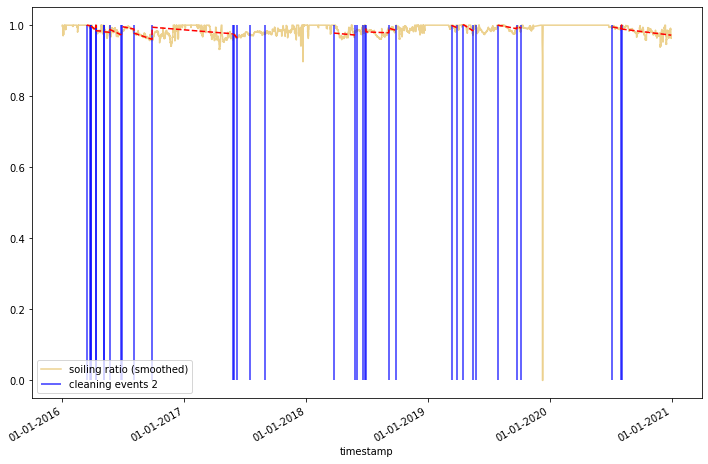

In [45]:
#ymin = min(df['soiling_derate'].values)

#ax1 = df['soiling_derate'].plot( color = 'goldenrod', label='soiling derate',figsize=(12,8))

derate2 = np.maximum(np.minimum(df_scaled.normalized_power/y_pred2,1),0.0)

derate2_smooth = derate2.rolling('4D', min_periods=1,center = True).median()

ymin = min(derate2_smooth)
ymax = max(derate2_smooth)
ax1 = derate2_smooth[start:end].plot( color = 'goldenrod', label='soiling ratio (smoothed)',figsize=(12,8), alpha = 0.5)

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.vlines(x=dates_changepoints2.intersection(pd.date_range(start = start, end = end, freq = '15T')), ymin=ymin, ymax=ymax, colors='blue', alpha = 0.6,ls='-', lw= 2, label='cleaning events 2')
ax1.xaxis.set_major_locator(mdates.YearLocator())
plotlines(derate2_smooth[start:end], dates_changepoints2.intersection(pd.date_range(start = start, end = end, freq = '15T')))
#ax1.vlines(x=starts_of_interv, ymin=ymin, ymax=1, colors='red', alpha = 1,ls='--', lw= 2, label='SRR')
#ax1.annotate('', xy=(0.379, 1.05), xycoords='axes fraction', xytext=(0.379, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))
#b=0.92
#ax1.annotate('', xy=(b, 1.05), xycoords='axes fraction', xytext=(b, 1), arrowprops=dict(arrowstyle="<-", color='green',lw =3))

ax1.legend()
plt.show()